# Feature Engineering

## Imports

In [1]:
import os
import re
import yaml
import random
import gensim

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

from scipy.sparse import save_npz
from nltk.corpus import opinion_lexicon
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from gensim.models import Word2Vec, FastText,Doc2Vec 

import sys
sys.path.append("../")
from src.feature_engineering import *
from src.utility import *

## Loading Config

In [2]:
with open("../config.yaml") as f:
    config = yaml.safe_load(f)
    config = config["feature_engineering"]
fix_config_types(config)
config

{'use_gpu': True,
 'random_seed': 42,
 'save_after_each_stage': True,
 'save_figure': True,
 'format': 'pkl',
 'cleaned_data': 'data/interim/IMDB_cleaned.pkl',
 'save_df_path': 'data/interim/IMDB_feature_engineered.pkl',
 'label_encoder': {'save_path': 'models/label_encoder.pkl'},
 'count_vectorizer': {'generate_count': False,
  'encoding': 'utf-8',
  'decode_error': 'strict',
  'strip_accents': None,
  'ngram_range': (1, 3),
  'analyzer': 'word',
  'max_df': 0.9,
  'min_df': 3,
  'max_features': 20000,
  'vocabulary': None,
  'binary': False,
  'save_vectorizer_path': 'models/count_vectorizer.pkl',
  'save_matrix_path': 'data/interim/count_vectorized_reviwes.npz'},
 'tfidf_vectorizer': {'generate_tfidf': False,
  'encoding': 'utf-8',
  'decode_error': 'strict',
  'strip_accents': None,
  'analyzer': 'word',
  'ngram_range': (1, 3),
  'max_df': 0.9,
  'min_df': 3,
  'max_features': 20000,
  'vocabulary': None,
  'binary': False,
  'norm': 'l2',
  'use_idf': True,
  'smooth_idf': True,


In [3]:
# --------------------------
# GENERAL SETTINGS
# --------------------------
USE_GPU = config["use_gpu"]
RANDOM_SEED = config["random_seed"]
SAVE_AFTER_EACH_STAGE = config["save_after_each_stage"]
FORMAT = config["format"]
CLEANED_DATA = os.path.join("../", config["cleaned_data"])
SAVE_DF_PATH = os.path.join("../", config["save_df_path"])
SAVE_FIGURE = config["save_figure"]
LE_SAVE_PATH = os.path.join("../", config["label_encoder"]["save_path"])

# --------------------------
# COUNT VECTORIZER CONFIG
# --------------------------
GENERATE_COUNT = config["count_vectorizer"]["generate_count"]
COUNT_ENCODING = config["count_vectorizer"]["encoding"]
COUNT_DECODE_ERROR = config["count_vectorizer"]["decode_error"]
COUNT_STRIP_ACCENTS = config["count_vectorizer"]["strip_accents"]
COUNT_NGRAM_RANGE = config["count_vectorizer"]["ngram_range"]
COUNT_ANALYZER = config["count_vectorizer"]["analyzer"]
COUNT_MAX_DF = config["count_vectorizer"]["max_df"]
COUNT_MIN_DF = config["count_vectorizer"]["min_df"]
COUNT_MAX_FEATURES = config["count_vectorizer"]["max_features"]
COUNT_VOCABULARY = config["count_vectorizer"]["vocabulary"]
COUNT_BINARY = config["count_vectorizer"]["binary"]
COUNT_VECTORIZER_PATH = os.path.join("../", config["count_vectorizer"]["save_vectorizer_path"])
COUNT_MATRIX_PATH = os.path.join("../", config["count_vectorizer"]["save_matrix_path"])

# --------------------------
# TF-IDF CONFIG
# --------------------------
GENERATE_TFIDF = config["tfidf_vectorizer"]["generate_tfidf"]
TFIDF_ENCODING = config["tfidf_vectorizer"]["encoding"]
TFIDF_DECODE_ERROR = config["tfidf_vectorizer"]["decode_error"]
TFIDF_STRIP_ACCENTS = config["tfidf_vectorizer"]["strip_accents"]
TFIDF_ANALYZER = config["tfidf_vectorizer"]["analyzer"]
TFIDF_NGRAM_RANGE = config["tfidf_vectorizer"]["ngram_range"]
TFIDF_MAX_DF = config["tfidf_vectorizer"]["max_df"]
TFIDF_MIN_DF = config["tfidf_vectorizer"]["min_df"]
TFIDF_MAX_FEATURES = config["tfidf_vectorizer"]["max_features"]
TFIDF_VOCABULARY = config["tfidf_vectorizer"]["vocabulary"]
TFIDF_BINARY = config["tfidf_vectorizer"]["binary"]
TFIDF_NORM = config["tfidf_vectorizer"]["norm"]
TFIDF_USE_IDF = config["tfidf_vectorizer"]["use_idf"]
TFIDF_SMOOTH_IDF = config["tfidf_vectorizer"]["smooth_idf"]
TFIDF_SUBLINEAR_TF = config["tfidf_vectorizer"]["sublinear_tf"]
TFIDF_VECTORIZER_PATH = os.path.join("../", config["tfidf_vectorizer"]["save_vectorizer_path"])
TFIDF_MATRIX_PATH = os.path.join("../", config["tfidf_vectorizer"]["save_matrix_path"])

# --------------------------
# W2V CONFIG
# --------------------------
W2V = config["w2v"]["w2v"]
W2V_VECTOR_SIZE = config["w2v"]["vector_size"]
W2V_WINDOW = config["w2v"]["window"]
W2V_MIN_COUNT = config["w2v"]["min_count"]
W2V_SG = config["w2v"]["sg"]
W2V_EPOCHS = config["w2v"]["epochs"]
W2V_WORKERS = config["w2v"]["workers"]
W2V_SAVE_PTAH = os.path.join("../", config["w2v"]["model_save_path"])
W2V_POOLING = config["w2v"]["pooling"] 
W2V_POOLING_BATCH_SIZE = config["w2v"]["pooling_batch_size"]
W2V_EMBEDDINGS_SAVE_PATH = os.path.join("../", config["w2v"]["embeddings_save_path"])
W2V_FIG_WORDS = config["w2v"]["fig_words"]
W2V_PLOT_3D = config["w2v"]["plot_3d"]
W2V_SAVE_FIG_PATH = os.path.join("../", config["w2v"]["save_fig_path"])

# --------------------------
# FastText CONFIG
# --------------------------
FT = config["fast_text"]["fast_text"]
FT_VECTOR_SIZE = config["fast_text"]["vector_size"]
FT_WINDOW = config["fast_text"]["window"]
FT_MIN_COUNT = config["fast_text"]["min_count"]
FT_SG = config["fast_text"]["sg"]
FT_EPOCHS = config["fast_text"]["epochs"]
FT_WORKERS = config["fast_text"]["workers"]
FT_SAVE_PTAH = os.path.join("../", config["fast_text"]["model_save_path"])
FT_POOLING = config["fast_text"]["pooling"] 
FT_POOLING_BATCH_SIZE = config["fast_text"]["pooling_batch_size"]
FT_EMBEDDINGS_SAVE_PATH = os.path.join("../", config["fast_text"]["embeddings_save_path"])
FT_FIG_WORDS = config["fast_text"]["fig_words"]
FT_PLOT_3D = config["fast_text"]["plot_3d"]
FT_SAVE_FIG_PATH = os.path.join("../", config["fast_text"]["save_fig_path"])

## Loading the data

In [4]:
if FORMAT == "csv":
    df = load_data_csv(CLEANED_DATA)
elif FORMAT == "pkl":
    df = load_pickle(CLEANED_DATA) 
df

,review,sentiment,review_charecters_len,review_word_len,has_html,cleaned_review,tokens,cleaned_review_charecter_len,cleaned_review_word_len,cleaned_review_has_html
0,One of the other reviewers has mentioned that ...,positive,1377,320,True,one reviewer mentioned watching oz episode hoo...,"[one, reviewer, mentioned, watching, oz, episo...",931,162,False
1,A wonderful little production. <br /><br />The...,positive,793,166,True,wonderful little production filming technique ...,"[wonderful, little, production, filming, techn...",557,84,False
2,I thought this was a wonderful way to spend ti...,positive,721,172,True,thought wonderful way spend time hot summer we...,"[thought, wonderful, way, spend, time, hot, su...",495,83,False
3,Basically there's a family where a little boy ...,negative,569,141,True,basically family little boy jake think zombie ...,"[basically, family, little, boy, jake, think, ...",362,62,False
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1032,236,True,petter matteis love time money visually stunni...,"[petter, matteis, love, time, money, visually,...",725,123,False
...,...,...,...,...,...,...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,769,205,True,thought movie right good job creative original...,"[thought, movie, right, good, job, creative, o...",416,75,False
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,505,115,True,bad plot bad dialogue bad acting idiotic direc...,"[bad, plot, bad, dialogue, bad, acting, idioti...",344,56,False
49997,I am a Catholic taught in parochial elementary...,negative,1006,240,True,catholic taught parochial elementary school nu...,"[catholic, taught, parochial, elementary, scho...",687,114,False
49998,I'm going to have to disagree with the previou...,negative,995,217,False,going disagree previous comment side maltin on...,"[going, disagree, previous, comment, side, mal...",698,112,False


## Lable Encoding Target(sentiment)

In [5]:
le = LabelEncoder()
df["sentiment"] = le.fit_transform(df["sentiment"])
save_pickle(le, LE_SAVE_PATH)
df["sentiment"].head()

0    1
1    1
2    1
3    0
4    1
Name: sentiment, dtype: int64

## Positive And Negative Words

In [6]:
# using sets to make the search operation constant time
pw = set(opinion_lexicon.positive())
nw = set(opinion_lexicon.negative())

In [7]:
"love" in pw, "hate" in nw

(True, True)

In [8]:
tokens = random.choice(df["tokens"].tolist())
tokens

['acting',
 'directing',
 'could',
 'argued',
 'merit',
 'storyline',
 'poor',
 'wannabe',
 'vietnam',
 'movie',
 'country',
 'name',
 'simply',
 'changedat',
 'least',
 'movie',
 'hold',
 'credibility',
 'try',
 'semblance',
 'accuracy',
 'equipment',
 'weapon',
 'tactic',
 'nevermind',
 'gross',
 'misrepresentation',
 'behaviour',
 'troop',
 'normaside',
 'limited',
 'use',
 'silly',
 'propaganda',
 'south',
 'african',
 'defence',
 'force',
 'serf',
 'little',
 'purpose',
 'definitely',
 'entertainment',
 'valueaspiring',
 'movie',
 'maker',
 'make',
 'war',
 'movie',
 'research',
 'pride',
 'product']

In [9]:
%%time
get_positive_words(tokens, positive_words=pw)

CPU times: user 24 μs, sys: 3 μs, total: 27 μs
Wall time: 31.9 μs


['merit', 'pride']

In [10]:
%%time
get_negative_words(tokens, negative_words=nw)

CPU times: user 23 μs, sys: 3 μs, total: 26 μs
Wall time: 33.1 μs


['poor', 'gross', 'misrepresentation', 'limited', 'silly', 'propaganda']

In [11]:
df["positive_tokens"] = df["tokens"].apply(lambda x: get_positive_words(x, positive_words=pw))
df["negative_tokens"] = df["tokens"].apply(lambda x: get_negative_words(x, negative_words=nw))

In [12]:
temp = df[["tokens", "positive_tokens", "negative_tokens"]].sample(1)
temp["positive_tokens"].tolist(), temp["negative_tokens"].tolist()

([['pretty',
   'good',
   'cure',
   'best',
   'well',
   'elite',
   'better',
   'humor',
   'originality',
   'perfect',
   'decent',
   'worthy']],
 [['disappointment',
   'poor',
   'bad',
   'choppy',
   'incoherent',
   'terrible',
   'lacked',
   'lack']])

In [13]:
temp["tokens"].tolist()

[['men',
  'black',
  'real',
  'disappointment',
  'actor',
  'pretty',
  'good',
  'job',
  'especially',
  'smith',
  'cure',
  'poor',
  'script',
  'production',
  'movie',
  'really',
  'sequel',
  'kind',
  'feel',
  'playing',
  'partial',
  'event',
  'first',
  'film',
  'story',
  'word',
  'bad',
  'best',
  'thought',
  'well',
  'seemed',
  'choppy',
  'incoherent',
  'timesin',
  'first',
  'flick',
  'mib',
  'organization',
  'kind',
  'elite',
  'force',
  'feel',
  'special',
  'agent',
  'clandestine',
  'kind',
  'feel',
  'sequel',
  'mib',
  'organization',
  'jrotc',
  'summer',
  'camp',
  'vibethe',
  'movie',
  'terrible',
  'anything',
  'lacked',
  'coolness',
  'lack',
  'better',
  'phrase',
  'first',
  'movie',
  'lot',
  'old',
  'humor',
  'recycled',
  'first',
  'second',
  'really',
  'add',
  'originality',
  'mib',
  'universea',
  'perfect',
  'analogy',
  'would',
  'episode',
  'first',
  'film',
  'decent',
  'yeah',
  'worthy',
  'bearing',


In [14]:
df["positive_tokens_len"] = df["positive_tokens"].apply(len)
df["negative_tokens_len"] = df["negative_tokens"].apply(len)

In [15]:
df.head()

,review,sentiment,review_charecters_len,review_word_len,has_html,cleaned_review,tokens,cleaned_review_charecter_len,cleaned_review_word_len,cleaned_review_has_html,positive_tokens,negative_tokens,positive_tokens_len,negative_tokens_len
0,One of the other reviewers has mentioned that ...,1,1377,320,True,one reviewer mentioned watching oz episode hoo...,"[one, reviewer, mentioned, watching, oz, episo...",931,162,False,"[right, right, trust, regard, classic, appeal,...","[struck, brutality, faint, timid, punch, priso...",13,20
1,A wonderful little production. <br /><br />The...,1,793,166,True,wonderful little production filming technique ...,"[wonderful, little, production, filming, techn...",557,84,False,"[wonderful, comforting, well, seamless, well, ...",[terribly],11,1
2,I thought this was a wonderful way to spend ti...,1,721,172,True,thought wonderful way spend time hot summer we...,"[thought, wonderful, way, spend, time, hot, su...",495,83,False,"[wonderful, hot, witty, likable, well, impress...","[plot, simplistic, killer, disappointed, risk,...",11,6
3,Basically there's a family where a little boy ...,0,569,141,True,basically family little boy jake think zombie ...,"[basically, family, little, boy, jake, think, ...",362,62,False,"[like, well]","[zombie, slower, kill, ruin, meaningless, ignore]",2,6
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,1032,236,True,petter matteis love time money visually stunni...,"[petter, matteis, love, time, money, visually,...",725,123,False,"[love, stunning, vivid, success, stylishly, so...","[loneliness, anxiously]",15,2


In [16]:
df[["sentiment", "positive_tokens_len","negative_tokens_len"]].describe()

,sentiment,positive_tokens_len,negative_tokens_len
count,50000.000000,50000.000000,50000.000000
mean,0.500000,9.734520,9.493540
std,0.500005,7.667152,8.586845
min,0.000000,0.000000,0.000000
25%,0.000000,5.000000,4.000000
50%,0.500000,8.000000,7.000000
75%,1.000000,12.000000,12.000000
max,1.000000,93.000000,121.000000


## Saving df

In [17]:
save_pickle(df, SAVE_DF_PATH)

## Count Vectorizer

In [18]:
countVecer = CountVectorizer(
    encoding='utf-8',                     # Character encoding (e.g., 'latin1' for non-UTF files)
    decode_error='strict',                # How to handle decode errors: 'strict', 'ignore', or 'replace'
    strip_accents=None,                   # 'ascii'/'unicode' removes accents (e.g., “café”→“cafe”)
    ngram_range=(1, 3),                   # Use unigrams only; (1,2) for unigrams + bigrams, etc.
    analyzer='word',                      # 'word' (default), 'char', or 'char_wb' for character n-grams
    max_df=1.0,                           # Ignore terms in >X% of docs (e.g., 0.9 removes common words)
    min_df=1,                             # Ignore terms in <X docs (e.g., 2 removes rare words)
    max_features=None,                    # Limit vocab size to top N most frequent tokens
    vocabulary=None,                      # Fixed vocabulary dict/list if you already know the terms
    binary=False,                         # If True, record presence (1/0) instead of counts
    dtype=float,                          # Type of matrix values (int, float, etc.)
)

In [19]:
r = df['cleaned_review'].sample(1)
countVectorized = countVecer.fit_transform(r)
r

19922    ernest worrell come third movie presentation j...
Name: cleaned_review, dtype: object

In [20]:
countVectorized.get_shape(), countVectorized

((1, 79),
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 79 stored elements and shape (1, 79)>)

In [21]:
countVecer.get_feature_names_out()

array(['book', 'book violence', 'come', 'come third', 'come third movie',
       'comic', 'comic book', 'comic book violence', 'double',
       'double evil', 'double evil mr', 'ernest', 'ernest double',
       'ernest double evil', 'ernest worrell', 'ernest worrell come',
       'evil', 'evil mr', 'evil mr nash', 'family', 'family film',
       'family film rated', 'film', 'film rated', 'film rated pg',
       'finish', 'finish movie', 'finish movie solid', 'good',
       'good family', 'good family film', 'jim', 'jim varney',
       'jim varney play', 'laugh', 'laugh make', 'laugh make good',
       'make', 'make good', 'make good family', 'movie',
       'movie presentation', 'movie presentation jim', 'movie solid',
       'movie solid laugh', 'mr', 'mr nash', 'mr nash start', 'nash',
       'nash start', 'nash start finish', 'pg', 'pg comic',
       'pg comic book', 'play', 'play ernest', 'play ernest double',
       'presentation', 'presentation jim', 'presentation jim varney',
  

In [22]:
pd.DataFrame(countVectorized.toarray(), columns=countVecer.get_feature_names_out())

,book,book violence,come,come third,come third movie,comic,comic book,comic book violence,double,double evil,...,third,third movie,third movie presentation,varney,varney play,varney play ernest,violence,worrell,worrell come,worrell come third
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [23]:
if GENERATE_COUNT:
    countVecer = CountVectorizer(
        encoding=COUNT_ENCODING,             # Character encoding (e.g., 'latin1' for non-UTF files)
        decode_error=COUNT_DECODE_ERROR,     # How to handle decode errors: 'strict', 'ignore', or 'replace'
        strip_accents=COUNT_STRIP_ACCENTS,   # 'ascii'/'unicode' removes accents (e.g., “café”→“cafe”)
        ngram_range=COUNT_NGRAM_RANGE,       # Use unigrams only; (1,2) for unigrams + bigrams, etc.
        analyzer=COUNT_ANALYZER,             # 'word' (default), 'char', or 'char_wb' for character n-grams
        max_df=COUNT_MAX_DF,                 # Ignore terms in >X% of docs (e.g., 0.9 removes common words)
        min_df=COUNT_MIN_DF,                 # Ignore terms in <X docs (e.g., 2 removes rare words)
        max_features=COUNT_MAX_FEATURES,     # Limit vocab size to top N most frequent tokens
        vocabulary=COUNT_VOCABULARY,         # Fixed vocabulary dict/list if you already know the terms
        binary=COUNT_BINARY,                 # If True, record presence (1/0) instead of counts
        dtype=np.float32,                    # Type of matrix values (int, float, etc.)
    )
    
    countVectorized = countVecer.fit_transform(df["cleaned_review"])
    
    save_pickle(countVecer, COUNT_VECTORIZER_PATH)
    save_npz(COUNT_MATRIX_PATH, countVectorized)
    
    print(countVectorized.shape, countVectorized.nnz)
    
    del countVectorized
    del countVecer

## Tf-idf Vectorizer

In [24]:
tfidfVecer = TfidfVectorizer(
    encoding='utf-8',                     # Character encoding (e.g., 'latin1' for some older corpora)
    decode_error='strict',                # How to handle decode errors: 'strict', 'ignore', or 'replace'
    strip_accents=None,                   # 'ascii'/'unicode' removes accents (“café”→“cafe”)
    analyzer='word',                      # 'word' (default), 'char', or 'char_wb' (within word boundaries)
    ngram_range=(1, 3),                   # Use unigrams only; (1,2) for unigrams + bigrams, etc.
    max_df=1.0,                           # Ignore terms in >X% of docs (e.g., 0.9 removes very common words)
    min_df=1,                             # Ignore terms in <X docs (e.g., 2 removes very rare words)
    max_features=None,                    # Keep only the top N features by frequency
    vocabulary=None,                      # Fixed vocab list/dict (useful for applying same vocab later)
    binary=False,                         # If True, use 1/0 instead of term frequency before TF-IDF scaling
    dtype=np.float32,                     # Matrix value type (float32 or float64)
    norm='l2',                            # Normalize vectors: 'l1', 'l2', or None (no normalization)
    use_idf=True,                         # Enable inverse document frequency weighting
    smooth_idf=True,                      # Adds 1 to document frequencies to avoid div-by-zero
    sublinear_tf=False,                   # If True, use log(1 + tf) for term frequency scaling
)

In [25]:
r = df['cleaned_review'].sample(1)
tfidfVectorized = tfidfVecer.fit_transform(r)
r

19125    cherish every frame beautiful movie regular pe...
Name: cleaned_review, dtype: object

In [26]:
tfidfVectorized.shape, tfidfVectorized.toarray(), tfidfVectorized

((1, 158),
 array([[0.07474351, 0.07474351, 0.07474351, 0.07474351, 0.07474351,
         0.07474351, 0.07474351, 0.07474351, 0.07474351, 0.07474351,
         0.07474351, 0.07474351, 0.14948702, 0.07474351, 0.07474351,
         0.07474351, 0.07474351, 0.07474351, 0.07474351, 0.07474351,
         0.07474351, 0.07474351, 0.07474351, 0.07474351, 0.07474351,
         0.07474351, 0.07474351, 0.07474351, 0.07474351, 0.07474351,
         0.07474351, 0.07474351, 0.14948702, 0.07474351, 0.07474351,
         0.07474351, 0.07474351, 0.07474351, 0.07474351, 0.07474351,
         0.07474351, 0.07474351, 0.07474351, 0.07474351, 0.07474351,
         0.07474351, 0.07474351, 0.07474351, 0.07474351, 0.07474351,
         0.07474351, 0.07474351, 0.07474351, 0.07474351, 0.07474351,
         0.14948702, 0.07474351, 0.07474351, 0.07474351, 0.07474351,
         0.07474351, 0.07474351, 0.07474351, 0.07474351, 0.07474351,
         0.07474351, 0.07474351, 0.07474351, 0.07474351, 0.14948702,
         0.07474351, 0.

In [27]:
tfidfVecer.get_feature_names_out()

array(['also', 'also delicate', 'also delicate moment', 'anything',
       'anything baker', 'anything baker putupon', 'around',
       'around like', 'around like robert', 'baggage', 'baggage carry',
       'baggage carry around', 'baker', 'baker breathe',
       'baker breathe life', 'baker putupon', 'baker putupon sister',
       'beautiful', 'beautiful movie', 'beautiful movie regular',
       'breathe', 'breathe life', 'breathe life portrayal', 'carry',
       'carry around', 'carry around like', 'cherish', 'cherish every',
       'cherish every frame', 'delicate', 'delicate moment',
       'delicate moment deniro', 'deniro', 'deniro ed',
       'deniro ed harris', 'deniro give', 'deniro give flower', 'drink',
       'drink feel', 'drink feel anything', 'ed', 'ed harris',
       'ed harris kathy', 'especially', 'especially heartbreaking',
       'especially heartbreaking therefore', 'every', 'every frame',
       'every frame beautiful', 'excellent', 'excellent harris',
       'ex

In [28]:
pd.DataFrame(tfidfVectorized.toarray(), columns=tfidfVecer.get_feature_names_out())

,also,also delicate,also delicate moment,anything,anything baker,anything baker putupon,around,around like,around like robert,baggage,...,therefore,therefore real,therefore real would,trucker,trucker drink,trucker drink feel,worthwhile,would,would swear,would swear really
0,0.074744,0.074744,0.074744,0.074744,0.074744,0.074744,0.074744,0.074744,0.074744,0.074744,...,0.074744,0.074744,0.074744,0.074744,0.074744,0.074744,0.074744,0.074744,0.074744,0.074744


In [29]:
if GENERATE_TFIDF:
    tfidfVecer = TfidfVectorizer(
        encoding=TFIDF_ENCODING,               # Character encoding (e.g., 'latin1' for some older corpora)
        decode_error=TFIDF_DECODE_ERROR,       # How to handle decode errors: 'strict', 'ignore', or 'replace'
        strip_accents=TFIDF_STRIP_ACCENTS,     # 'ascii'/'unicode' removes accents (“café”→“cafe”)
        analyzer=TFIDF_ANALYZER,               # 'word' (default), 'char', or 'char_wb' (within word boundaries)
        ngram_range=TFIDF_NGRAM_RANGE,         # Use unigrams only; (1,2) for unigrams + bigrams, etc.
        max_df=TFIDF_MAX_DF,                   # Ignore terms in >X% of docs (e.g., 0.9 removes very common words)
        min_df=TFIDF_MIN_DF,                   # Ignore terms in <X docs (e.g., 2 removes very rare words)
        max_features=TFIDF_MAX_FEATURES,       # Keep only the top N features by frequency
        vocabulary=TFIDF_VOCABULARY,           # Fixed vocab list/dict (useful for applying same vocab later)
        binary=TFIDF_BINARY,                   # If True, use 1/0 instead of term frequency before TF-IDF scaling
        dtype=np.float32,                      # Matrix value type (float32 or float64)
        norm=TFIDF_NORM,                       # Normalize vectors: 'l1', 'l2', or None (no normalization)
        use_idf=TFIDF_USE_IDF,                 # Enable inverse document frequency weighting
        smooth_idf=TFIDF_SMOOTH_IDF,           # Adds 1 to document frequencies to avoid div-by-zero
        sublinear_tf=TFIDF_SUBLINEAR_TF,       # If True, use log(1 + tf) for term frequency scaling
    )
    
    tfidfVectorized = tfidfVecer.fit_transform(df['cleaned_review'])
    
    print(tfidfVectorized.shape, tfidfVectorized.nnz)
    
    save_pickle(tfidfVecer, TFIDF_VECTORIZER_PATH)
    save_npz(TFIDF_MATRIX_PATH, tfidfVectorized)
    
    del tfidfVectorized
    del tfidfVecer

## Word to Vec models

### W2V

In [30]:
if W2V:
    w2v = Word2Vec(sentences=df["tokens"].tolist(), 
                   vector_size=W2V_VECTOR_SIZE, 
                   window=W2V_WINDOW, min_count=W2V_MIN_COUNT, 
                   sg=W2V_SG, epochs=W2V_EPOCHS, workers=W2V_WORKERS)
    w2v.save(W2V_SAVE_PTAH)
    print(w2v.wv.most_similar('actor'))
    print(w2v.wv.most_similar("good"))
    print(w2v.wv.most_similar(positive=["actor", "woman"], negative=["man"]))
    print(w2v.wv.similarity("actor", "woman"), w2v.wv.similarity("actress", "woman"))
    r = w2v.wv['actor'] - w2v.wv['man'] + w2v.wv['woman']
    print(w2v.wv.similar_by_vector(r))

[('venal', 0.2541438341140747), ('downgrade', 0.22715307772159576), ('patiently', 0.2246485948562622), ('villain', 0.2235267460346222), ('wajda', 0.21494567394256592), ('flopped', 0.2106916904449463), ('century', 0.20911087095737457), ('arkin', 0.2081729620695114), ('grabbed', 0.20759066939353943), ('baptism', 0.206340491771698)]
[('exotic', 0.2580218017101288), ('santo', 0.2481982558965683), ('blacksmith', 0.2310451716184616), ('langella', 0.2171274721622467), ('peed', 0.20839224755764008), ('undisputed', 0.2056414932012558), ('impressivei', 0.20323793590068817), ('circus', 0.2031862437725067), ('narrator', 0.2018582820892334), ('beneath', 0.1992671638727188)]
[('sockpuppet', 0.2528936564922333), ('chapter', 0.23831437528133392), ('cctv', 0.23643429577350616), ('taryn', 0.2180393934249878), ('tulsa', 0.21282437443733215), ('tighe', 0.21213021874427795), ('via', 0.2107212394475937), ('emotionalism', 0.21061818301677704), ('triggering', 0.208798348903656), ('wajda', 0.20826171338558197)

In [31]:
if W2V:
    w2v_review_vecs = convert_tokens_to_vectors(
        tokens_list=df["tokens"].tolist(), 
        w2v_model=w2v, 
        pooling=W2V_POOLING, 
        batch_size=W2V_POOLING_BATCH_SIZE
    )
    np.save(W2V_EMBEDDINGS_SAVE_PATH, w2v_review_vecs)
    print(w2v_review_vecs, w2v_review_vecs.shape)

[[ 4.2732398e-05  1.9302557e-04 -5.8641137e-05 ... -8.2263170e-05
   1.1703277e-04  1.8301233e-05]
 [ 5.2201816e-05  2.7585472e-04 -3.4006036e-06 ...  2.5638103e-04
   3.5770788e-04  5.7117966e-05]
 [ 1.2033064e-04  4.1904690e-04  6.5128232e-05 ... -1.8050938e-04
  -5.1984804e-05  3.3234592e-04]
 ...
 [ 1.7658886e-04 -4.0092540e-04 -2.8987983e-04 ... -2.0702722e-04
  -2.3320242e-04  2.6683396e-05]
 [ 8.9120213e-06  4.4251559e-05  2.6783053e-04 ...  2.2672680e-04
   8.6163520e-05  1.1480367e-04]
 [ 3.1963334e-04  1.7563683e-04  4.5814701e-05 ...  2.6755944e-07
   2.3819497e-04 -3.0530614e-04]] (50000, 300)


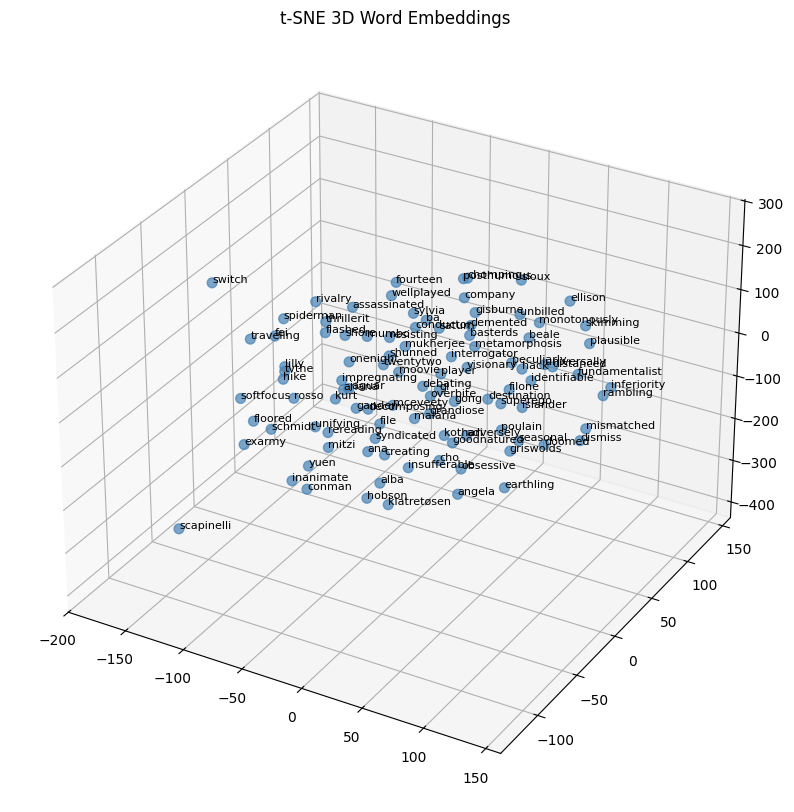

In [32]:
if W2V:
    tsne_plot(
        w2v, 
        number_of_words=W2V_FIG_WORDS, 
        plot_3d=W2V_PLOT_3D, 
        save_figure=SAVE_FIGURE, 
        save_path=W2V_SAVE_FIG_PATH
    )

### FastText 

In [33]:
if FT:
    ft = FastText(sentences=df["tokens"].tolist(), 
                  vector_size=FT_VECTOR_SIZE, 
                  window=FT_WINDOW, 
                  min_count=FT_MIN_COUNT, sg=FT_SG, 
                  epochs=FT_EPOCHS, workers=FT_WORKERS)
    ft.save(FT_SAVE_PTAH)
    print(ft.wv.most_similar('smart'))
    print(ft.wv.most_similar("good"))
    print(ft.wv.most_similar(positive=["king", "girl"], negative=["boy"]))
    print(ft.wv.similarity("king", "girl"), w2v.wv.similarity("queen", "girl")) 
    r = ft.wv['king'] - ft.wv['boy'] + ft.wv['girl']
    print(ft.wv.similar_by_vector(r))

[('outsmart', 0.5683782696723938), ('smarter', 0.5341701507568359), ('streetsmart', 0.5262489318847656), ('smartest', 0.5078085660934448), ('smartly', 0.47602853178977966), ('smartaleck', 0.4750869572162628), ('mart', 0.44146814942359924), ('smartass', 0.4342176914215088), ('kmart', 0.3593417704105377), ('smash', 0.3305506110191345)]
[('goody', 0.5411157011985779), ('goodas', 0.5270947217941284), ('goodif', 0.519572913646698), ('goodand', 0.48619481921195984), ('goodi', 0.4856874942779541), ('goodygoody', 0.4723361134529114), ('goode', 0.4678071439266205), ('goodthe', 0.45598605275154114), ('goodguy', 0.4541243314743042), ('aregood', 0.4537118077278137)]
[('kingsleys', 0.32266560196876526), ('risktaking', 0.31349337100982666), ('kingsley', 0.31001219153404236), ('girlgirl', 0.29809537529945374), ('alltalking', 0.29413512349128723), ('girlie', 0.2794238030910492), ('talking', 0.25237298011779785), ('tarentino', 0.25110459327697754), ('releasing', 0.24939526617527008), ('girli', 0.247367

In [34]:
if FT:
    ft_review_vecs = convert_tokens_to_vectors(
        tokens_list=df["tokens"].tolist(), 
        w2v_model=ft, 
        pooling=FT_POOLING, 
        batch_size=FT_POOLING_BATCH_SIZE
    )
    np.save(FT_EMBEDDINGS_SAVE_PATH, ft_review_vecs)
    print(ft_review_vecs, ft_review_vecs.shape)

[[-6.6969544e-05  1.2518477e-04 -4.2904787e-05 ... -4.0195704e-05
   3.1100648e-05  1.0234203e-04]
 [ 3.2393200e-05  6.5292777e-05  9.3015711e-05 ...  1.8614657e-05
   3.4350687e-05 -2.1807471e-05]
 [-5.8460555e-05  4.4842258e-05 -5.5201858e-06 ... -8.6712225e-06
   7.8284222e-07  7.0465743e-05]
 ...
 [-3.8746020e-05 -2.0151558e-05 -5.0451687e-05 ...  7.9341517e-05
  -1.3307451e-04  1.9107008e-05]
 [ 9.5819523e-05  2.8076585e-05 -4.1894738e-05 ...  8.5966829e-05
  -1.6641678e-05  6.1878171e-05]
 [-4.2576972e-05  1.4548826e-04 -2.1013392e-04 ... -8.9874033e-05
   2.0178821e-05  4.0462419e-05]] (50000, 300)


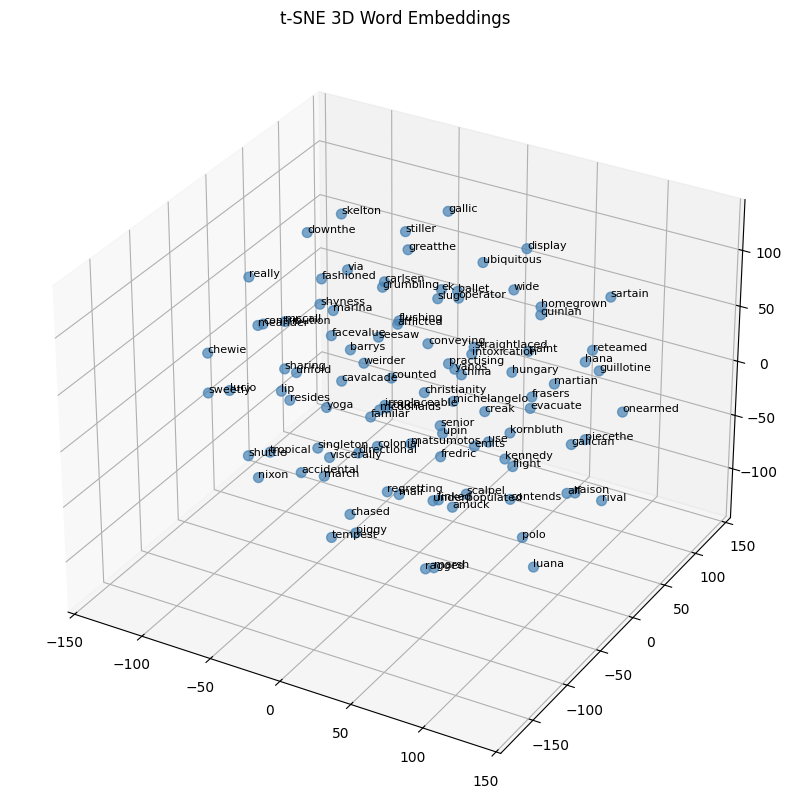

In [35]:
if FT:
    tsne_plot(
        ft, 
        number_of_words=FT_FIG_WORDS, 
        plot_3d=FT_PLOT_3D, 
        save_figure=SAVE_FIGURE, 
        save_path=FT_SAVE_FIG_PATH
    )